In [1]:
import psycopg2
from pprint import pprint
import pandas.io.sql as sqlio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
# Connect to an existing database
conn = psycopg2.connect("dbname=postgres user=sejaldua")

In [3]:
# preview the dataset
sql = "SELECT * FROM olympics"
master_df = sqlio.read_sql_query(sql, conn)
master_df

,id,name,sex,age,height,weight,team,noc,games,year,season,city,sport,event,medal
0,1,A Dijiang,M,24,180,80,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NA
1,2,A Lamusi,M,23,170,60,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NA
2,3,Gunnar Nielsen Aaby,M,24,NA,NA,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NA
3,4,Edgar Lindenau Aabye,M,34,NA,NA,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21,185,82,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29,179,89,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NA
271112,135570,Piotr ya,M,27,176,59,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NA
271113,135570,Piotr ya,M,27,176,59,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NA
271114,135571,Tomasz Ireneusz ya,M,30,185,96,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NA


### Answering questions I have about the data

In [4]:
sql = """
SELECT year, region FROM olympics
LEFT JOIN noc_regions
ON olympics.noc = noc_regions.noc
WHERE sport = 'Basketball' and sex = 'F' and medal = 'Gold'
GROUP BY year, region
ORDER BY year DESC
"""
df = sqlio.read_sql_query(sql, conn)
df

,year,region
0,2016,USA
1,2012,USA
2,2008,USA
3,2004,USA
4,2000,USA
5,1996,USA
6,1992,Russia
7,1988,USA
8,1984,USA
9,1980,Russia


Sheesh. USA Women's Basketball team has not had a taste of defeat since 1992. That is 6 straight Gold medals!

In [6]:
sql = """
SELECT name, COUNT(*) FROM olympics
WHERE sport = 'Basketball' and sex = 'F' and medal = 'Gold' and noc = 'USA'
GROUP BY name
HAVING COUNT(*) >= 3
ORDER BY count DESC
"""
df = sqlio.read_sql_query(sql, conn)
df

,name,count
0,Lisa Deshawn Leslie (-Lockwood),4
1,"Suzanne Brigit ""Sue"" Bird",4
2,Diana Lurena Taurasi,4
3,Tamika Devonne Catchings,4
4,Teresa Edwards,4
5,Sheryl Denice Swoopes,3
6,"Katherine May ""Katie"" Smith",3
7,Seimone Delicia Augustus,3
8,Dawn Michelle Staley,3
9,Sylvia Shaqueria Fowles,3


These queens have showed up 3+ times, bringing home the Gold and making Team USA proud!

### Number of Athletes Competing over Time

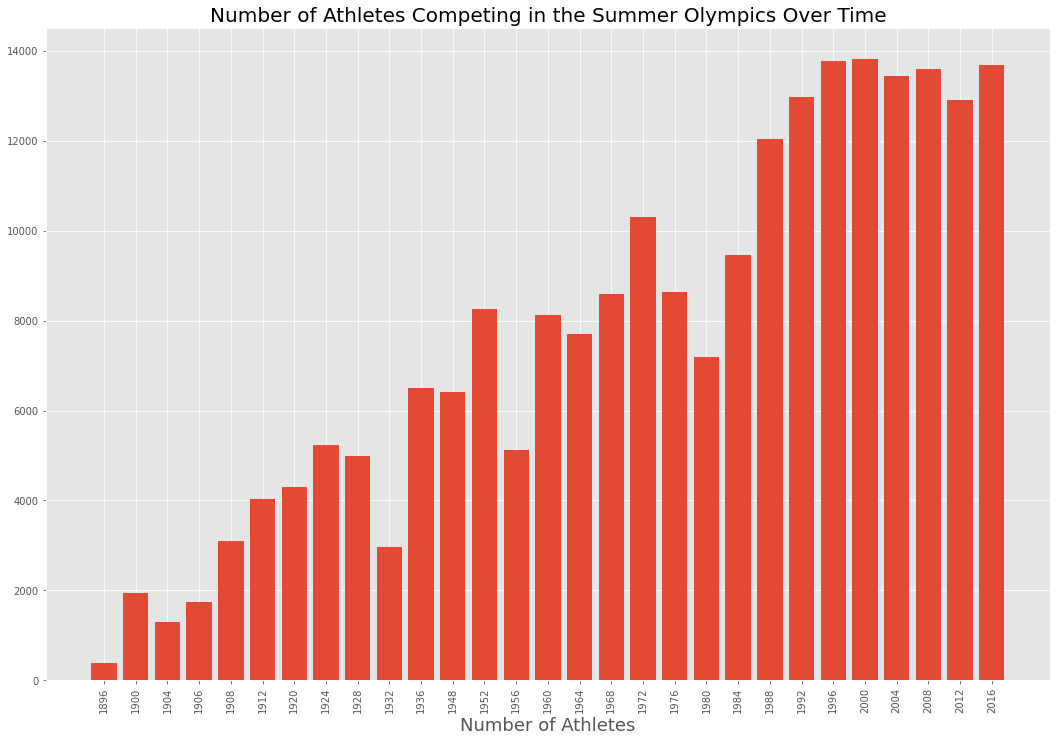

In [8]:
sql = """
SELECT year, COUNT(*) AS num_athletes FROM olympics
WHERE season = 'Summer'
GROUP BY year
"""
df = sqlio.read_sql_query(sql, conn)
# df
fig = plt.figure(figsize=(18,12))
plt.bar(df['year'].astype(str), df['num_athletes'])
plt.xlabel('Number of Athletes', fontsize=18)
plt.title('Number of Athletes Competing in the Summer Olympics Over Time', fontsize=20)
plt.xticks(rotation=90);
fig.savefig("./figures/num_athletes_over_time.png")

### Number of Athletes per Sport

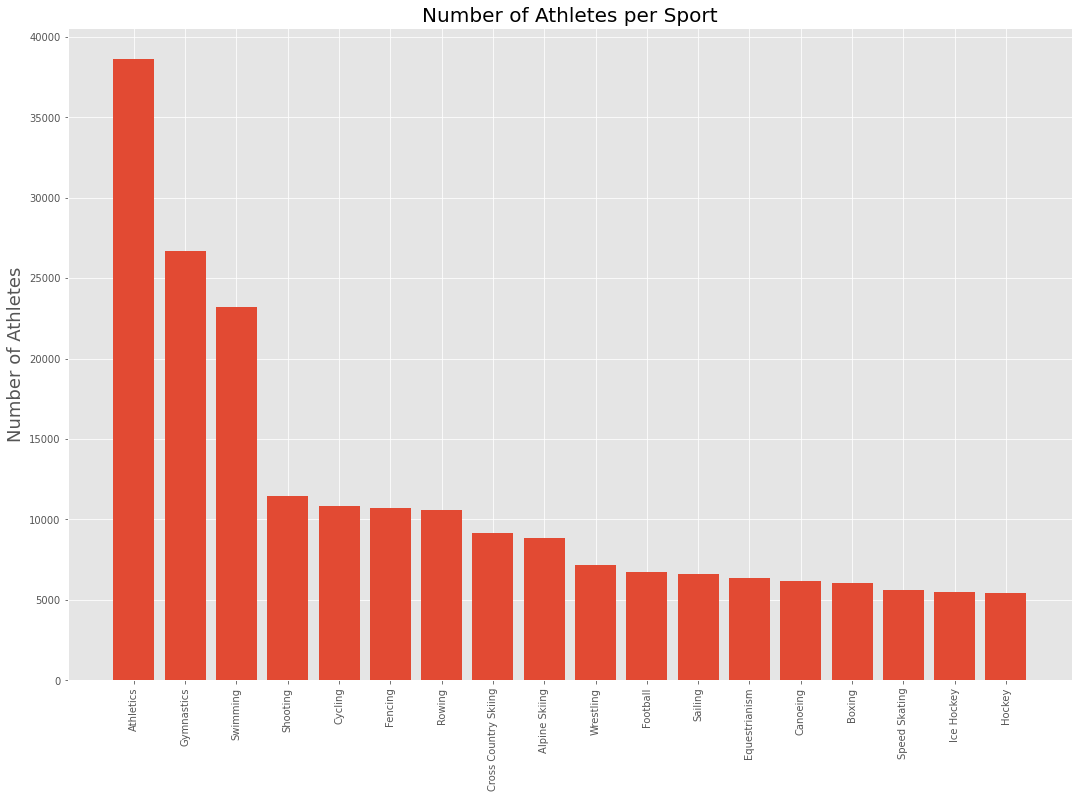

In [22]:
sql = """
SELECT sport, COUNT(*) AS num_athletes FROM olympics
GROUP BY sport
HAVING COUNT(*) > 5000
ORDER BY COUNT(*) DESC
"""
df = sqlio.read_sql_query(sql, conn)
# df
fig = plt.figure(figsize=(18,12))
plt.bar(df['sport'], df['num_athletes'])
plt.ylabel('Number of Athletes', fontsize=18)
plt.title('Number of Athletes per Sport', fontsize=20)
plt.xticks(rotation=90);
fig.savefig("./figures/num_athletes_per_sport.png")

### Number of Athletes per Region

In [26]:
sql = """
SELECT region, COUNT(*) AS num_athletes FROM olympics
LEFT JOIN noc_regions
ON noc_regions.noc = olympics.noc
WHERE region LIKE '%'
GROUP BY region
ORDER BY COUNT(*) DESC
"""
df = sqlio.read_sql_query(sql, conn)
df

,region,num_athletes
0,USA,18853
1,Germany,15883
2,France,12758
3,UK,12256
4,Russia,11692
...,...,...
201,Kiribati,11
202,Brunei,10
203,Timor-Leste,9
204,Kosovo,8


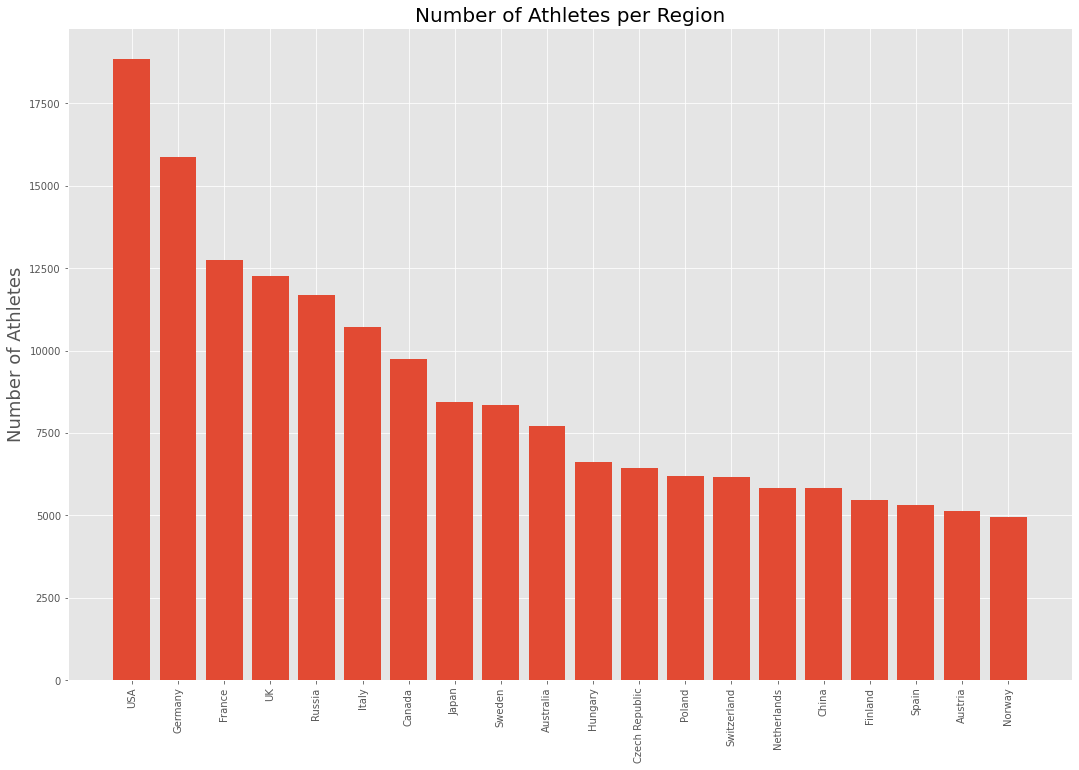

In [27]:
fig = plt.figure(figsize=(18,12))
plt.bar(df['region'][:20], df['num_athletes'][:20])
plt.ylabel('Number of Athletes', fontsize=18)
plt.title('Number of Athletes per Region', fontsize=20)
plt.xticks(rotation=90);
fig.savefig("./figures/num_athletes_per_region.png")

### Number of Events per Sport

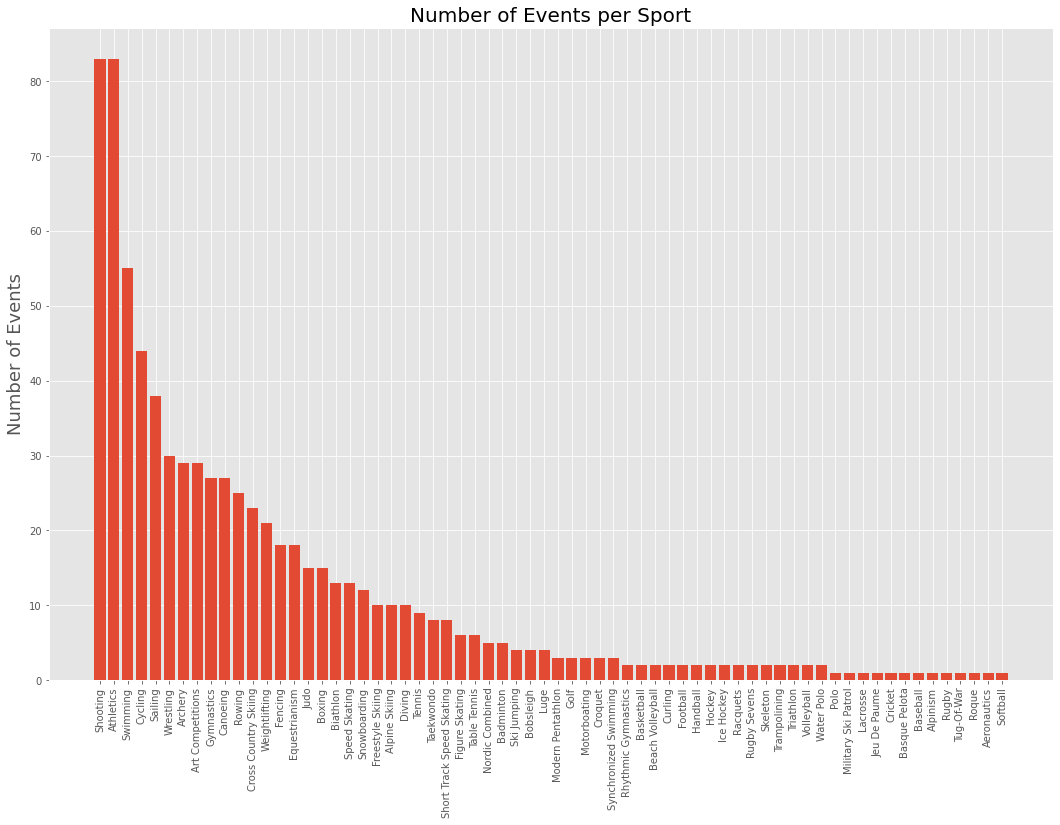

In [28]:
sql = """
SELECT sport, COUNT(DISTINCT event) FROM olympics
GROUP BY sport
ORDER BY COUNT(DISTINCT event) DESC
"""
df = sqlio.read_sql_query(sql, conn)
# df
fig = plt.figure(figsize=(18,12))
plt.bar(df['sport'], df['count'])
plt.ylabel('Number of Events', fontsize=18)
plt.title('Number of Events per Sport', fontsize=20)
plt.xticks(rotation=90);
fig.savefig("./figures/num_events_per_sport.png")

### Analyzing Athletic Build (Height and Weight) by Sport

In [16]:
# most popular sports by number of athletes
sql = """
SELECT DISTINCT sport FROM olympics
WHERE year >= 2014
"""
pop_sports = list(sqlio.read_sql_query(sql, conn)['sport'])

In [17]:
# shortest gymnasts
sql = """
SELECT DISTINCT name, CAST(height AS INTEGER), CAST(weight AS DECIMAL), region FROM olympics
LEFT OUTER JOIN noc_regions
ON olympics.noc = noc_regions.noc
WHERE sport = 'Gymnastics' AND sex = 'F' AND height <> 'NA' AND weight <> 'NA'
ORDER BY height
LIMIT 10
"""
df = sqlio.read_sql_query(sql, conn)
df

,name,height,weight,region
0,Rosario Briones,127,42.0,Mexico
1,Ana Olvido Manso Gallego,132,31.0,Spain
2,Flvia Lopes Saraiva,133,31.0,Brazil
3,Choi Myong-Hui,135,25.0,North Korea
4,Jana Labkov (-Valachov),135,34.0,Czech Republic
5,Crystal Gilmore,136,47.0,Canada
6,Liubov Sheremeta,136,30.0,Ukraine
7,Lu Li,136,30.0,China
8,Mariya Yevgenyevna Filatova (-Kurbatova),136,30.0,Russia
9,Claudia Fragapane,137,43.0,UK


In [18]:
# tallest gymnasts
sql = """
SELECT DISTINCT name, CAST(height AS INTEGER), CAST(weight AS DECIMAL), region FROM olympics
LEFT OUTER JOIN noc_regions
ON olympics.noc = noc_regions.noc
WHERE sport = 'Gymnastics' AND sex = 'F' AND height <> 'NA' AND weight <> 'NA'
ORDER BY height DESC
LIMIT 10
"""
df = sqlio.read_sql_query(sql, conn)
df

,name,height,weight,region
0,Arja Vellamo Lehtinen (-Paatsalo),179,62.0,Finland
1,Agata Jadwiga Jaroszek-Karczmarek,178,61.0,Poland
2,Bndicte Evrard,176,38.0,Belgium
3,Fan Ye,176,72.0,China
4,"Sandra Marlene Ruddick (Anderson-, -John)",176,59.0,USA
5,Katarna arisk (-Mulders),174,44.0,Czech Republic
6,Christine Schmitt (-Dressel),172,54.0,Germany
7,Salme Kaarina Koskinen (-Paimander),172,56.0,Finland
8,Marie-Sophie Hindermann,171,51.0,Germany
9,Ute Starke (-Kahlenberg),171,49.0,Germany


In [43]:
sql = """
SELECT sport, MIN(CAST(height AS INTEGER)), ROUND(AVG(CAST(height AS INTEGER)), 2) AS avg, MAX(CAST(height AS INTEGER))
FROM olympics
WHERE sex = 'F' AND height <> 'NA' AND weight <> 'NA'
GROUP BY sport
ORDER BY avg
"""
female_body_df = sqlio.read_sql_query(sql, conn)
female_body_df

,sport,min,avg,max
0,Gymnastics,127,156.16,179
1,Weightlifting,141,160.47,190
2,Figure Skating,137,160.55,180
3,Diving,137,161.28,178
4,Trampolining,154,161.73,172
5,Wrestling,147,163.87,180
6,Ski Jumping,152,164.31,175
7,Short Track Speed Skating,150,164.53,182
8,Freestyle Skiing,150,164.77,183
9,Shooting,146,164.93,190


In [42]:
sql = """
SELECT sport, MIN(CAST(height AS INTEGER)), ROUND(AVG(CAST(height AS INTEGER)), 2) AS avg, MAX(CAST(height AS INTEGER))
FROM olympics
WHERE sex = 'M' AND height <> 'NA' AND weight <> 'NA'
GROUP BY sport
ORDER BY avg
"""
male_body_df = sqlio.read_sql_query(sql, conn)
male_body_df

,sport,min,avg,max
0,Gymnastics,150,167.61,188
1,Weightlifting,140,169.15,205
2,Trampolining,162,171.46,185
3,Diving,148,171.65,188
4,Art Competitions,150,172.82,188
5,Boxing,127,172.84,208
6,Wrestling,137,172.91,214
7,Rugby,164,173.67,183
8,Lacrosse,168,174.00,180
9,Short Track Speed Skating,162,175.61,191


In [74]:
sql = """
SELECT F.sport, F.min AS F_min, F.avg AS F_avg, F.max AS F_max, M.min AS M_min, M.avg AS M_avg, M.max AS M_max, (F.avg + M.avg) AS avg_sum FROM
(SELECT sport, MIN(CAST(height AS INTEGER)), ROUND(AVG(CAST(height AS INTEGER)), 2) AS avg, MAX(CAST(height AS INTEGER))
FROM olympics
WHERE sex = 'F' AND height <> 'NA' AND weight <> 'NA'
GROUP BY sport
ORDER BY avg) F,
(SELECT sport, MIN(CAST(height AS INTEGER)), ROUND(AVG(CAST(height AS INTEGER)), 2) AS avg, MAX(CAST(height AS INTEGER))
FROM olympics
WHERE sex = 'M' AND height <> 'NA' AND weight <> 'NA'
GROUP BY sport
ORDER BY avg) M
WHERE F.sport = M.sport
ORDER BY avg_sum;
"""
df = sqlio.read_sql_query(sql, conn)
df

,sport,f_min,f_avg,f_max,m_min,m_avg,m_max,avg_sum
0,Gymnastics,127,156.16,179,150,167.61,188,323.77
1,Weightlifting,141,160.47,190,140,169.15,205,329.62
2,Diving,137,161.28,178,148,171.65,188,332.93
3,Trampolining,154,161.73,172,162,171.46,185,333.19
4,Figure Skating,137,160.55,180,156,176.04,193,336.59
5,Wrestling,147,163.87,180,137,172.91,214,336.78
6,Short Track Speed Skating,150,164.53,182,162,175.61,191,340.14
7,Ski Jumping,152,164.31,175,156,176.65,200,340.96
8,Shooting,146,164.93,190,132,176.07,213,341.00
9,Freestyle Skiing,150,164.77,183,149,176.37,197,341.14


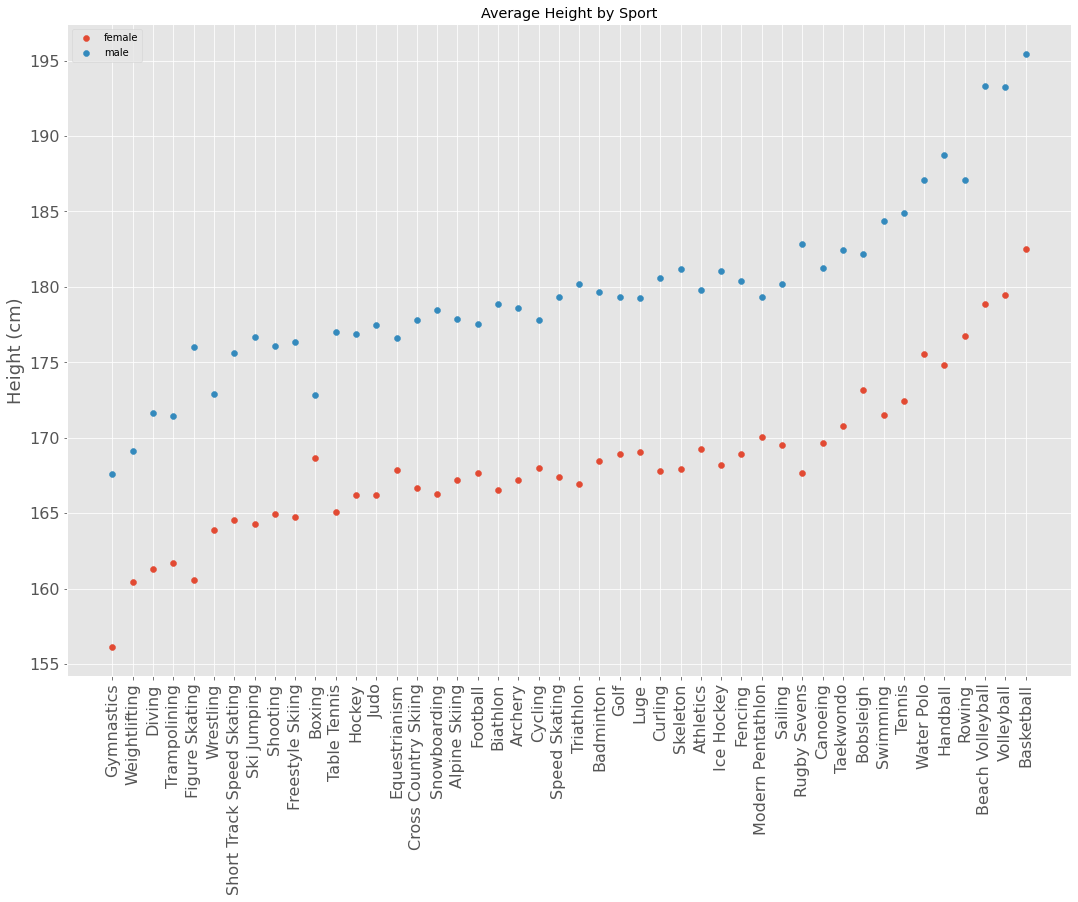

In [75]:
fig = plt.figure(figsize=(18,12))
plt.scatter(df['sport'], df['f_avg'], label='female')
plt.scatter(df['sport'], df['m_avg'], label='male')
plt.xticks(rotation=90, fontsize=16);
plt.yticks(fontsize=16)
plt.ylabel('Height (cm)', fontsize=18);
plt.title('Average Height by Sport')
plt.legend()

In [72]:
sql = """
SELECT F.sport, F.min AS F_min, F.avg AS F_avg, F.max AS F_max, M.min AS M_min, M.avg AS M_avg, M.max AS M_max, (F.avg + M.avg) AS avg_sum FROM
(SELECT sport, MIN(CAST(weight AS DECIMAL)), ROUND(AVG(CAST(weight AS DECIMAL)), 2) AS avg, MAX(CAST(weight AS DECIMAL))
FROM olympics
WHERE sex = 'F' AND height <> 'NA' AND weight <> 'NA'
GROUP BY sport
ORDER BY avg) F,
(SELECT sport, MIN(CAST(weight AS DECIMAL)), ROUND(AVG(CAST(weight AS DECIMAL)), 2) AS avg, MAX(CAST(weight AS DECIMAL))
FROM olympics
WHERE sex = 'M' AND height <> 'NA' AND weight <> 'NA'
GROUP BY sport
ORDER BY avg) M
WHERE F.sport = M.sport
ORDER BY avg_sum;
"""
df = sqlio.read_sql_query(sql, conn)
df

,sport,f_min,f_avg,f_max,m_min,m_avg,m_max,avg_sum
0,Gymnastics,25.0,47.79,72.0,46.0,63.34,102.0,111.13
1,Ski Jumping,43.0,52.62,62.0,50.0,65.25,85.0,117.87
2,Trampolining,43.0,52.89,60.0,57.0,65.84,84.0,118.73
3,Figure Skating,32.0,49.86,68.0,47.0,69.59,90.0,119.45
4,Diving,28.0,53.57,75.0,37.0,67.07,91.0,120.64
5,Triathlon,44.0,54.72,72.0,54.0,68.80,82.0,123.52
6,Boxing,50.0,61.64,79.0,46.0,65.29,140.0,126.93
7,Short Track Speed Skating,43.0,57.12,73.0,51.0,71.40,86.0,128.52
8,Cross Country Skiing,42.0,57.49,77.0,53.0,71.70,100.0,129.19
9,Table Tennis,42.0,57.93,79.0,50.0,71.41,99.0,129.34


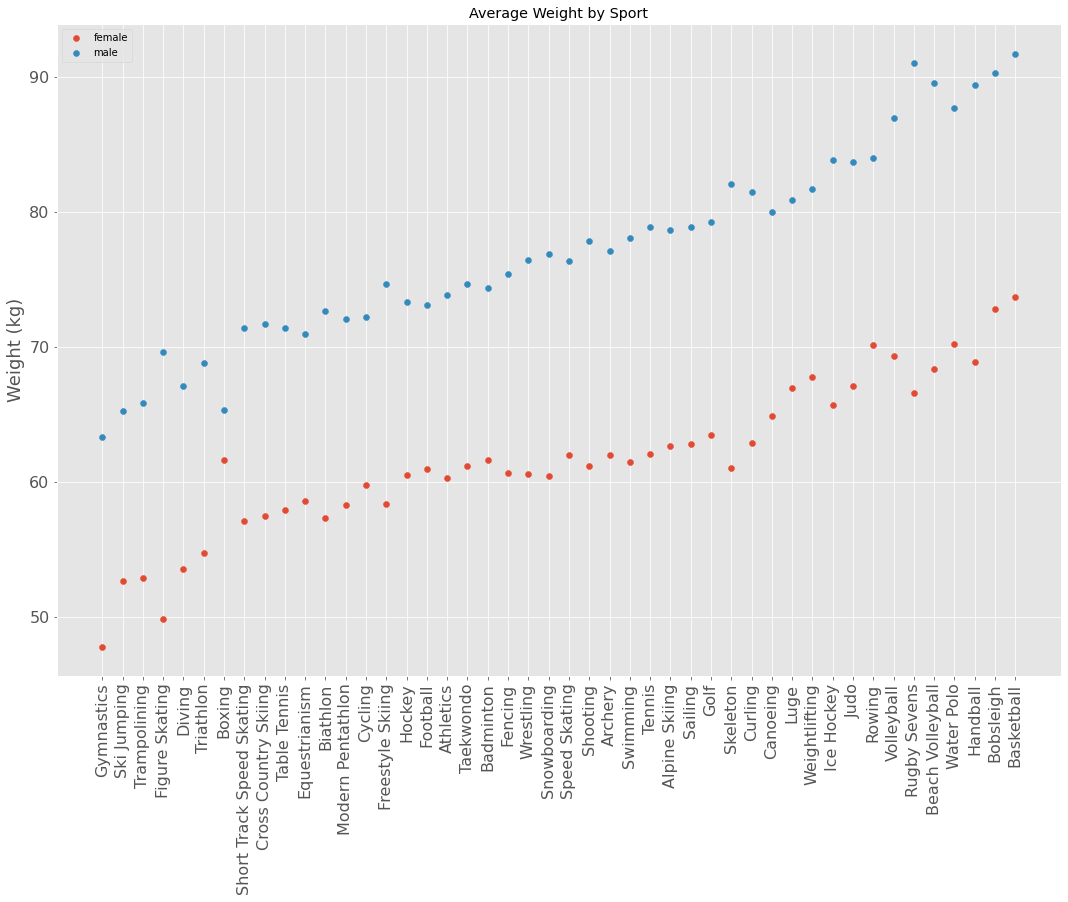

In [73]:
fig = plt.figure(figsize=(18,12))
plt.scatter(df['sport'], df['f_avg'], label='female')
plt.scatter(df['sport'], df['m_avg'], label='male')
plt.xticks(rotation=90, fontsize=16);
plt.yticks(fontsize=16)
plt.ylabel('Weight (kg)', fontsize=18);
plt.title('Average Weight by Sport')
plt.legend()

<AxesSubplot:xlabel='year'>

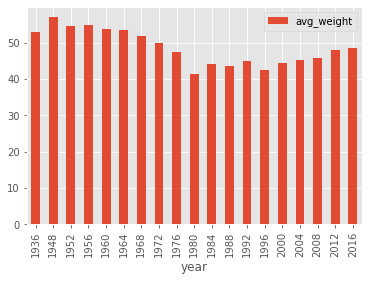

In [157]:
# WEIGHT STATS by Year
sql = """
SELECT year, ROUND(AVG(CAST(weight AS DECIMAL)), 2) AS avg_weight
FROM olympics
WHERE sport = 'Gymnastics' AND sex = 'F' AND weight <> 'NA'
GROUP BY year;
"""
df = sqlio.read_sql_query(sql, conn)
df.plot('year', 'avg_weight', kind='bar')

<AxesSubplot:xlabel='height', ylabel='weight'>

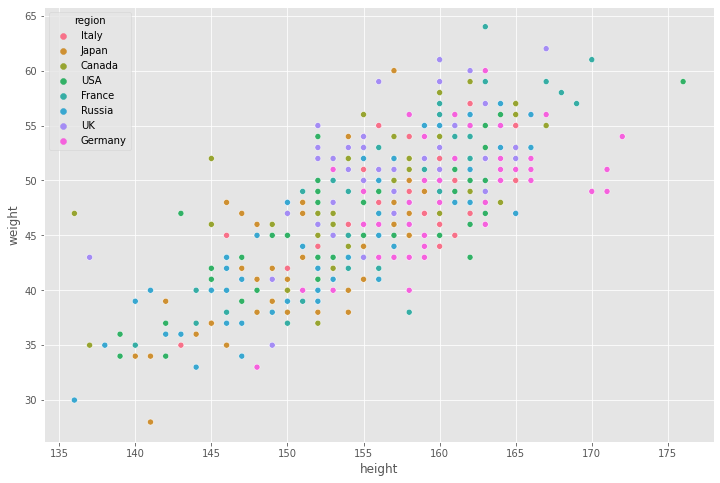

In [80]:
sql = """
SELECT DISTINCT name, CAST(height AS INTEGER), CAST(weight AS DECIMAL), region
FROM olympics
LEFT JOIN noc_regions
ON olympics.noc = noc_regions.noc
WHERE sport = 'Gymnastics' AND sex = 'F' AND height <> 'NA' AND weight <> 'NA' 
AND region IN
(SELECT region FROM olympics
LEFT JOIN noc_regions
ON olympics.noc = noc_regions.noc
GROUP BY region
ORDER BY COUNT(DISTINCT name) DESC
LIMIT 8)
"""
df = sqlio.read_sql_query(sql, conn)
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df, x='height', y='weight', hue='region')
# plt.show()
# df.plot('height', 'weight', kind='scatter', figsize=(10,6))

<AxesSubplot:xlabel='age'>

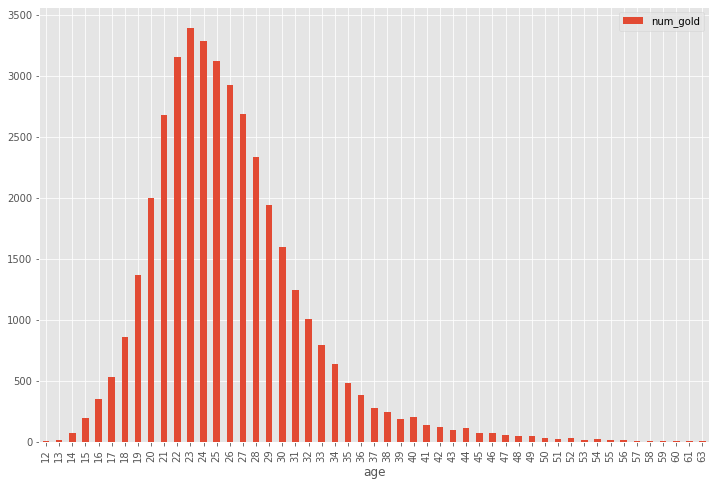

In [82]:
# Age Distribution of Olympic Medalists
sql = """
SELECT age, SUM(CASE medal
            WHEN 'Gold' THEN 1
            WHEN 'Silver' THEN 1
            WHEN 'Bronze' THEN 1
            ELSE 0
            END) AS num_gold
FROM olympics
WHERE age <> 'NA'
GROUP BY age
HAVING SUM(CASE medal
            WHEN 'Gold' THEN 1
            WHEN 'Silver' THEN 1
            WHEN 'Bronze' THEN 1
            ELSE 0
            END) > 3
"""
df = sqlio.read_sql_query(sql, conn)
df['age'] = df['age'].astype(int)
df.plot('age', 'num_gold', kind='bar', figsize=(12,8))

In [181]:
sql = """
SELECT
  name, noc, sport, SUM(CASE medal
             WHEN 'Gold' THEN 3
             WHEN 'Silver' THEN 2
             WHEN 'Bronze' THEN 1
             ELSE 0
             END)
FROM 
  olympics
GROUP BY 
  name, noc, sport
ORDER BY sum DESC
LIMIT 10;
"""
df = sqlio.read_sql_query(sql, conn)
df

,name,noc,sport,sum
0,"Michael Fred Phelps, II",USA,Swimming,77
1,Larysa Semenivna Latynina (Diriy-),URS,Gymnastics,41
2,Nikolay Yefimovich Andrianov,URS,Gymnastics,34
3,Paavo Johannes Nurmi,FIN,Athletics,33
4,Ole Einar Bjrndalen,NOR,Biathlon,33
5,"Jennifer Elisabeth ""Jenny"" Thompson (-Cumpelik)",USA,Swimming,31
6,Borys Anfiyanovych Shakhlin,URS,Gymnastics,31
7,Sawao Kato,JPN,Gymnastics,31
8,"Raymond Clarence ""Ray"" Ewry",USA,Athletics,30
9,Edoardo Mangiarotti,ITA,Fencing,30


In [182]:
sql = """
SELECT
  name, sport, SUM(CASE medal
             WHEN 'Gold' THEN 3
             WHEN 'Silver' THEN 2
             WHEN 'Bronze' THEN 1
             ELSE 0
             END)
FROM 
  olympics
WHERE 
    noc = 'USA'
GROUP BY 
  name, sport
ORDER BY sum DESC
LIMIT 10;
"""
df = sqlio.read_sql_query(sql, conn)
df

,name,sport,sum
0,"Michael Fred Phelps, II",Swimming,77
1,"Jennifer Elisabeth ""Jenny"" Thompson (-Cumpelik)",Swimming,31
2,Mark Andrew Spitz,Swimming,30
3,"Raymond Clarence ""Ray"" Ewry",Athletics,30
4,"Frederick Carlton ""Carl"" Lewis",Athletics,29
5,"Matthew Nicholas ""Matt"" Biondi",Swimming,29
6,Ryan Steven Lochte,Swimming,27
7,Carl Townsend Osburn,Shooting,25
8,Allyson Michelle Felix,Athletics,24
9,"Dara Grace Torres (-Hoffman, -Minas)",Swimming,24


In [188]:
sql = """
SELECT
  name, noc, sport, COUNT(CASE medal
             WHEN 'Gold' THEN 1
             WHEN 'Silver' THEN 1
             WHEN 'Bronze' THEN 1
             ELSE 0
             END) AS num_medals
FROM 
  olympics
GROUP BY 
  name, noc, sport
ORDER BY num_medals DESC
LIMIT 10;
"""
df = sqlio.read_sql_query(sql, conn)
df

,name,noc,sport,num_medals
0,Robert Tait McKenzie,CAN,Art Competitions,58
1,Heikki Ilmari Savolainen,FIN,Gymnastics,39
2,"Joseph ""Josy"" Stoffel",LUX,Gymnastics,38
3,Ioannis Theofilakis,GRE,Shooting,36
4,Alexandros Theofilakis,GRE,Shooting,32
5,Takashi Ono,JPN,Gymnastics,32
6,Jean Lucien Nicolas Jacoby,LUX,Art Competitions,32
7,Michel Mathiot,FRA,Gymnastics,31
8,"Johann ""Hans"" Sauter",AUT,Gymnastics,31
9,"Alfred August ""Al"" Jochim",USA,Gymnastics,31


In [190]:
sql = """
SELECT
  name, noc, sport, 
             SUM(CASE medal
                WHEN 'Gold' THEN 1
                ELSE 0
                END) AS num_gold,
             SUM(CASE medal
                WHEN 'Silver' THEN 1
                ELSE 0
                END) AS num_silver,
            SUM(CASE medal
             WHEN 'Bronze' THEN 1
             ELSE 0
             END) AS num_bronze
FROM 
  olympics
WHERE sex = 'F'
GROUP BY 
  name, noc, sport
ORDER BY num_gold DESC
LIMIT 10;
"""
df = sqlio.read_sql_query(sql, conn)
df

,name,noc,sport,num_gold,num_silver,num_bronze
0,Larysa Semenivna Latynina (Diriy-),URS,Gymnastics,9,5,4
1,"Jennifer Elisabeth ""Jenny"" Thompson (-Cumpelik)",USA,Swimming,8,3,1
2,Vra slavsk (-Odloilov),TCH,Gymnastics,7,4,0
3,Lidiya Pavlovna Skoblikova (-Polozkova),URS,Speed Skating,6,0,0
4,Isabelle Regina Werth,GER,Equestrianism,6,4,0
5,Maria Valentina Vezzali,ITA,Fencing,6,1,2
6,Amy Deloris Van Dyken (-Rouen),USA,Swimming,6,0,0
7,Marit Bjrgen,NOR,Cross Country Skiing,6,3,1
8,Allyson Michelle Felix,USA,Athletics,6,3,0
9,Kristin Otto,GDR,Swimming,6,0,0


In [191]:
sql = """
SELECT
  name, noc, sport, 
             SUM(CASE medal
                WHEN 'Gold' THEN 1
                ELSE 0
                END) AS num_gold,
             SUM(CASE medal
                WHEN 'Silver' THEN 1
                ELSE 0
                END) AS num_silver,
            SUM(CASE medal
             WHEN 'Bronze' THEN 1
             ELSE 0
             END) AS num_bronze
FROM 
  olympics
WHERE sex = 'M'
GROUP BY 
  name, noc, sport
ORDER BY num_gold DESC
LIMIT 10;
"""
df = sqlio.read_sql_query(sql, conn)
df

,name,noc,sport,num_gold,num_silver,num_bronze
0,"Michael Fred Phelps, II",USA,Swimming,23,3,2
1,"Raymond Clarence ""Ray"" Ewry",USA,Athletics,10,0,0
2,"Frederick Carlton ""Carl"" Lewis",USA,Athletics,9,1,0
3,Mark Andrew Spitz,USA,Swimming,9,1,1
4,Paavo Johannes Nurmi,FIN,Athletics,9,3,0
5,Sawao Kato,JPN,Gymnastics,8,3,1
6,Ole Einar Bjrndalen,NOR,Biathlon,8,4,1
7,"Matthew Nicholas ""Matt"" Biondi",USA,Swimming,8,2,1
8,Usain St. Leo Bolt,JAM,Athletics,8,0,0
9,Aladr Gerevich (-Gerei),HUN,Fencing,7,1,2


In [146]:
# OLYMPIC DOMINANCE
sql = """
SELECT
  noc, sport, SUM(CASE medal
             WHEN 'Gold' THEN 3
             WHEN 'Silver' THEN 2
             WHEN 'Bronze' THEN 1
             ELSE 0
             END)
FROM 
  olympics
GROUP BY 
  sport, 
  noc
ORDER BY sum DESC
LIMIT 15;
"""
df = sqlio.read_sql_query(sql, conn)
df

,noc,sport,sum
0,USA,Swimming,2630
1,USA,Athletics,2481
2,USA,Basketball,927
3,CAN,Ice Hockey,881
4,USA,Rowing,848
5,AUS,Swimming,799
6,ITA,Fencing,797
7,URS,Gymnastics,669
8,FRA,Fencing,660
9,GBR,Athletics,627


<AxesSubplot:xlabel='year'>

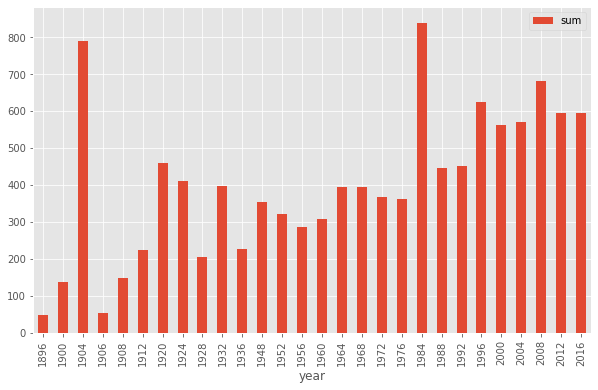

In [166]:
sql = """
SELECT year, SUM(CASE medal
             WHEN 'Gold' THEN 3
             WHEN 'Silver' THEN 2
             WHEN 'Bronze' THEN 1
             ELSE 0
             END)
FROM olympics
WHERE noc = 'USA' and season = 'Summer'
GROUP BY year;
"""
df = sqlio.read_sql_query(sql, conn)
df.plot('year', 'sum', kind='bar', figsize=(10, 6))

<AxesSubplot:xlabel='sport'>

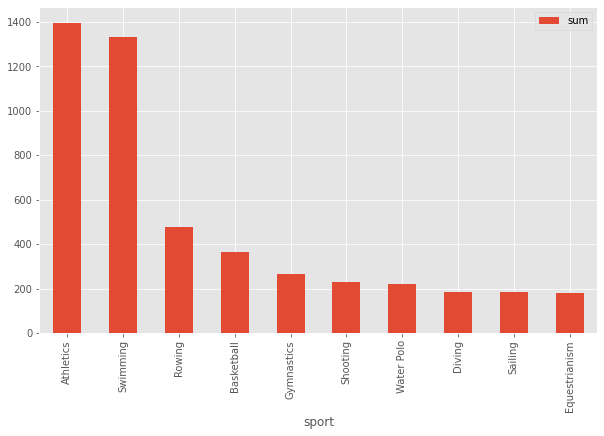

In [179]:
sql = """
SELECT sport, SUM(CASE medal
             WHEN 'Gold' THEN 1
             WHEN 'Silver' THEN 2
             WHEN 'Bronze' THEN 1
             ELSE 0
             END)
FROM olympics
WHERE noc = 'USA' and season = 'Summer'
GROUP BY sport
ORDER BY sum DESC
LIMIT 10;
"""
df = sqlio.read_sql_query(sql, conn)
df.plot('sport', 'sum', kind='bar', figsize=(10, 6))

<AxesSubplot:xlabel='sport'>

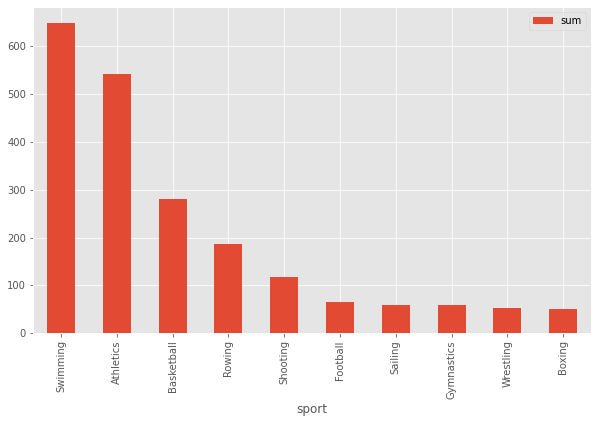

In [180]:
sql = """
SELECT sport, SUM(CASE medal
             WHEN 'Gold' THEN 1
             ELSE 0
             END)
FROM olympics
WHERE noc = 'USA' and season = 'Summer'
GROUP BY sport
ORDER BY sum DESC
LIMIT 10;
"""
df = sqlio.read_sql_query(sql, conn)
df.plot('sport', 'sum', kind='bar', figsize=(10, 6))

In [ ]:
# Close communication with the database
conn.close()